In [1]:
import os
os.chdir("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Lutz/CELL2RNA/all_code")
os.environ["CUDA_VISIBLE_DEVICES"] = '3'

In [2]:
import os
import sys
import importlib
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
import torch
import pickle
import PIL
from torchvision.models.detection.mask_rcnn import MaskRCNN, MaskRCNNPredictor, MaskRCNNHeads, MaskRCNN_ResNet50_FPN_V2_Weights
from torchvision.models.resnet import resnet50
from torchvision.models.detection.backbone_utils import _resnet_fpn_extractor, _validate_trainable_layers
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FastRCNNConvFCHead, RPNHead, _default_anchorgen
from torch import nn

In [3]:
from utils import numpify, select
from DataManager import dataManager
from spatialomicsslide import SpatialOmicsSlide, load_training_data
from patchesdataset import preprocess_wsi
from utils_1 import getModel, extractData

In [4]:
from dataset import ImageDataset
from visualize import visualize
from constants import Constants as C

# Detection

In [5]:
def preprocess(imgs):
    pimgs = []
    for img in imgs:
        pimg = img / 255
        pimg = pimg.transpose(2, 0, 1)
        for i in range(len(pimg)):
            pimg[i] = (pimg[i] - C.means[i]) / C.stds[i]
        pimg = pimg.astype('float32')
        pimgs.append(pimg)
    return pimgs

In [6]:
device = torch.device('cuda')
def generateDetections(model, dm: dataManager, batchsize=10):
    patches = dm.patches
    polygons, classes, X, Y = {}, {}, {}, {}
    for name in dm.snames:
        print(f"Processing Slide: {name}")
        polygons[name], classes[name], X[name], Y[name] = [], [], [], []
        indexes = list(range(len(patches[name])))
        batchIndexes = [indexes[i:i+batchsize] for i in range(0, len(indexes)-batchsize, batchsize)]
        remainder = len(indexes) % batchsize
        batchIndexes.append(indexes[len(patches[name])-remainder-1:])
        for ind in tqdm(batchIndexes):
            imgs = [dm.patches[name][i] for i in ind]
            imgts = [torch.tensor(img).to(device) for img in preprocess(imgs)]
            output = model(imgts)

            # stop overallocating memory
            for imgt in imgts:
                del imgt
            del imgts
            torch.cuda.synchronize()

            for o in output:
                m, c, b, s = extractData(o, debug=False)
                contours, imgpatches, cxs, cys = [], [], [], []
                for i in range(len(m)):
                    mask = m[i].astype(np.uint8)
                    contour, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                    contours.append(contour)

                    box = b[i]
                    cx = int(box[0] + (box[2] - box[0]) / 2)
                    cy = int(box[1] + (box[3] - box[1]) / 2)
                    cxs.append(cx)
                    cys.append(cy)

                polygons[name].append(contours)
                classes[name].append(c)
                X[name].append(cxs)
                Y[name].append(cys)

                del o
                torch.cuda.synchronize()

            del output
            torch.cuda.synchronize()
    return polygons, classes, X, Y

In [7]:
# load model
snames = ['A1', 'B1', 'C1', 'D1']
dm = dataManager(snames, load_patches=True, load_detections=False)

Generating Patches...


/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (178781337 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Fetching Expression...
Loading slide from cache: A1
Loading slide from cache: B1
Loading slide from cache: C1
Loading slide from cache: D1


In [8]:
os.chdir("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Lutz/CELL2RNA/all_code")
maskrcnn = getModel("../spatial_omics/code/MaskRCNN/models/maskrcnn_resnet50_1_10.pt")
maskrcnn.eval();

In [9]:
polygons, classes, X, Y = generateDetections(maskrcnn, dm, batchsize=10)

Processing Slide: A1


100%|███████████████████████████████████████████████████████████████████████| 271/271 [03:12<00:00,  1.41it/s]


Processing Slide: B1


100%|███████████████████████████████████████████████████████████████████████| 271/271 [03:11<00:00,  1.41it/s]


Processing Slide: C1


100%|███████████████████████████████████████████████████████████████████████| 271/271 [03:11<00:00,  1.41it/s]


Processing Slide: D1


100%|███████████████████████████████████████████████████████████████████████| 271/271 [03:09<00:00,  1.43it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


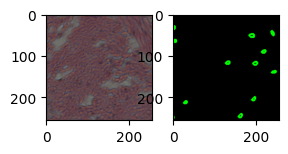

In [10]:
blank = np.zeros((256, 256, 3))
slide = 'B1'; ind = 400
plt.figure(figsize=(3,3))

plt.subplot(1, 2, 1)
plt.imshow(dm.patches[slide][ind])

plt.subplot(1, 2, 2)
# should plot all contours???
for i in range(len(polygons[slide][ind])):
    cv2.drawContours(blank, polygons[slide][ind][i], 0, (0,255,0), 3)
plt.imshow(blank)

In [ ]:
# Save things! polygons, classes, boxes, X, Y
storeDir = '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Lutz/CELL2RNA/spatial_omics/code/GNN/store/'
with open(storeDir + 'polygons.pickle', 'wb') as handle:
    pickle.dump(polygons, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(storeDir + 'classes.pickle', 'wb') as handle:
    pickle.dump(classes, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(storeDir + 'xcoords.pickle', 'wb') as handle:
    pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open(storeDir + 'ycoords.pickle', 'wb') as handle:
    pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)

# CNN

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
import os
import copy

In [12]:
from graphgen import generateCellPatches, generateCellLabels, neighborFinder
from EmbeddingDataset import EmbeddingDataset, train_val_dataset, connectedComponents

In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
def train_model(model, criterion, optimizer, scheduler=None, num_epochs=25):
    since = time.time()
    model = model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e9

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    labels = torch.squeeze(labels)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
            if phase == 'train' and scheduler is not None:
                scheduler.step()

            epoch_loss = running_loss / len(datasets[phase])

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [14]:
# MSE on raw counts.
binary = False
model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 1000)
model.to(device);
# maybe make this ZINB? 
criterion = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=0.001)
# optim = torch.optim.Adam(model.parameters(), lr=0.00001)

In [15]:
# Binary Cross Entropy Loss.
binary = True
model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1000),
    nn.Sigmoid()
)
model.to(device);
criterion = nn.functional.binary_cross_entropy
# optim = torch.optim.Adam(model.parameters(), lr=0.001)
optim = torch.optim.Adam(model.parameters(), lr=0.0001)

In [16]:
snames = ['A1', 'B1', 'C1', 'D1']
dm = dataManager(snames)

Loading Detections...
Fetching Expression...
Loading slide from cache: A1
Loading slide from cache: B1
Loading slide from cache: C1
Loading slide from cache: D1


In [17]:
snames = ['A1', 'B1', 'C1', 'D1']
cellpatches = generateCellPatches(snames, dm)
celllabels, ind = generateCellLabels(snames, dm)

Average number of visium nodes used per embedding: 0.7643645248730577
Total zero embeddings: 6172
Average number of visium nodes used per embedding: 0.7026858213616489
Total zero embeddings: 7140
Average number of visium nodes used per embedding: 0.725512104283054
Total zero embeddings: 5896
Average number of visium nodes used per embedding: 0.6950401847164869
Total zero embeddings: 6868


In [18]:
len(cellpatches['A1'])

26193

In [19]:
type(cellpatches['A1'])

list

In [20]:
len(celllabels['A1'])

26193

In [21]:
type(celllabels['A1'])

list

In [22]:
cellpatches['A1'][0].shape

(101, 101, 3)

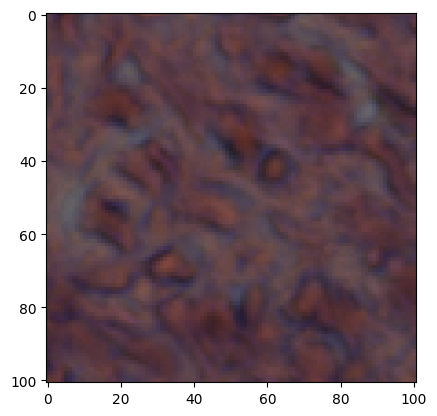

In [23]:
plt.imshow(cellpatches['A1'][1000])
plt.show()

In [24]:
celllabels['A1'][1000]

array([[ 4.00000003, 27.00000053,  0.        ,  0.        ,  2.00000002,
         0.        ,  2.00000002,  0.        ,  4.99999975, 12.99999982,
         2.00000002,  1.00000001,  0.        ,  0.        ,  1.00000001,
         6.00000005,  0.        ,  0.        ,  4.99999975,  1.00000001,
         0.        ,  0.        ,  6.00000005,  0.        ,  0.        ,
         1.00000001,  2.00000002,  0.        ,  1.00000001,  0.        ,
         1.00000001,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.00000001,  0.        ,  0.        ,
         1.00000001,  0.        ,  0.        ,  0.        ,  4.00000003,
         0.        ,  3.00000003,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  8.00000007,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.00000001,  0.        ,  0.        ,
         0.        ,  1.00000001,  0.        ,  0. 

In [25]:
# fuse all slides into one dataset.
patches, labels = [], []
fpos = {}
for key in cellpatches:
    patches.extend(select(cellpatches[key], ind[key]))
    if binary:
        labels.extend(select((np.array(celllabels[key] > dm.med_ex[key]))
                              .astype('int'), ind[key]))
    else: 
        labels.extend(select(celllabels[key], ind[key]))
    fpos[key] = select(dm.detxy[key], ind[key])

In [26]:
len(patches)

68133

In [27]:
len(labels)

68133

In [28]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = EmbeddingDataset(patches, labels, image_transform=transform, target_transform=transform)
datasets = train_val_dataset(dataset, fpos, 50)
dataloaders = {x: torch.utils.data.DataLoader(datasets[x], batch_size=64, \
                shuffle=True, num_workers=4) for x in ['train', 'val']}

Valid Shuffle: True


In [29]:
print(len(dataloaders['train']))
print(len(dataloaders['val']))

957
109


In [108]:
storeDir = './CNN_models'

In [109]:
model = train_model(model, criterion, optim, num_epochs=10)

Epoch 0/9
----------


100%|███████████████████████████████████████████████████████████████████████| 949/949 [00:26<00:00, 36.03it/s]


train Loss: 0.4570


100%|███████████████████████████████████████████████████████████████████████| 116/116 [00:01<00:00, 59.64it/s]


val Loss: 0.4343

Epoch 1/9
----------


100%|███████████████████████████████████████████████████████████████████████| 949/949 [00:26<00:00, 36.46it/s]


train Loss: 0.4077


100%|███████████████████████████████████████████████████████████████████████| 116/116 [00:02<00:00, 57.78it/s]


val Loss: 0.4301

Epoch 2/9
----------


100%|███████████████████████████████████████████████████████████████████████| 949/949 [00:26<00:00, 35.89it/s]


train Loss: 0.3887


100%|███████████████████████████████████████████████████████████████████████| 116/116 [00:02<00:00, 54.62it/s]


val Loss: 0.4319

Epoch 3/9
----------


100%|███████████████████████████████████████████████████████████████████████| 949/949 [00:25<00:00, 36.56it/s]


train Loss: 0.3756


100%|███████████████████████████████████████████████████████████████████████| 116/116 [00:01<00:00, 59.85it/s]


val Loss: 0.4290

Epoch 4/9
----------


100%|███████████████████████████████████████████████████████████████████████| 949/949 [00:26<00:00, 36.16it/s]


train Loss: 0.3680


100%|███████████████████████████████████████████████████████████████████████| 116/116 [00:02<00:00, 56.89it/s]


val Loss: 0.4282

Epoch 5/9
----------


100%|███████████████████████████████████████████████████████████████████████| 949/949 [00:26<00:00, 36.39it/s]


train Loss: 0.3618


100%|███████████████████████████████████████████████████████████████████████| 116/116 [00:02<00:00, 57.04it/s]


val Loss: 0.4353

Epoch 6/9
----------


100%|███████████████████████████████████████████████████████████████████████| 949/949 [00:26<00:00, 36.43it/s]


train Loss: 0.3566


100%|███████████████████████████████████████████████████████████████████████| 116/116 [00:01<00:00, 58.96it/s]


val Loss: 0.4285

Epoch 7/9
----------


100%|███████████████████████████████████████████████████████████████████████| 949/949 [00:25<00:00, 36.98it/s]


train Loss: 0.3525


100%|███████████████████████████████████████████████████████████████████████| 116/116 [00:02<00:00, 52.90it/s]


val Loss: 0.4308

Epoch 8/9
----------


100%|███████████████████████████████████████████████████████████████████████| 949/949 [00:27<00:00, 34.25it/s]


train Loss: 0.3488


100%|███████████████████████████████████████████████████████████████████████| 116/116 [00:01<00:00, 58.35it/s]


val Loss: 0.4286

Epoch 9/9
----------


100%|███████████████████████████████████████████████████████████████████████| 949/949 [00:26<00:00, 36.14it/s]


train Loss: 0.3452


100%|███████████████████████████████████████████████████████████████████████| 116/116 [00:02<00:00, 56.87it/s]

val Loss: 0.4323

Training complete in 4m 43s


In [110]:
with open(f'{storeDir}/modelkey.txt', "r") as f:
    modelkey = int(str(f.read()))
    torch.save(model.state_dict(), f"{storeDir}/v{modelkey}.pt")

with open(f'{storeDir}/modelkey.txt', "w") as f:
    f.write(str(modelkey+1))

In [118]:
# Load model from save.
storeDir = './CNN_models'
model = models.resnet18(weights='ResNet18_Weights.DEFAULT')
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 1000)

# model.fc = nn.Sequential(
#     nn.Linear(num_ftrs, 1000),
#     nn.Sigmoid()
# )

model.cuda()

modelkey=8
state_dict = torch.load("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/spatial_omics/code/GNN/store/cnn_models/embeddingsV1.pt", map_location=device)
# state_dict = torch.load(f"{storeDir}/v4.pt", map_location='cuda')
model.load_state_dict(state_dict)
model.eval();

In [30]:
import matplotlib
from visualize_2 import plotHeatmaps, plotAUROC

In [31]:
def fetchPatchTensor(patch):
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    return preprocess(patch)

In [32]:
slides = ['A1', 'B1', 'C1', 'D1']
celllabels, ind = generateCellLabels(slides, dm)
cellpatches = generateCellPatches(slides, dm)
transform = transforms.Compose([transforms.ToTensor()])
dataloaders = {}
for name in slides:
    dataset = EmbeddingDataset(cellpatches[name], celllabels[name], image_transform=fetchPatchTensor, target_transform=transform)
    dataloaders[name] = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

Average number of visium nodes used per embedding: 0.7643645248730577
Total zero embeddings: 6172
Average number of visium nodes used per embedding: 0.7026858213616489
Total zero embeddings: 7140
Average number of visium nodes used per embedding: 0.725512104283054
Total zero embeddings: 5896
Average number of visium nodes used per embedding: 0.6950401847164869
Total zero embeddings: 6868


In [33]:
# TODO: save labels for all genes in one place.
# We need to map our saved labels back to their original locations.
# Don't shuffle, read in all data, match it up with all cell detections.
preds = {}
for name in dm.snames:
    preds[name] = []
    for inputs, labels in tqdm(dataloaders[name]):
        inputs = inputs.to(device)
        # inputs = torch.stack([fetchPatchTensor(el) for el in inputs]).to(device)
        labels = labels.to(device)
        torch.cuda.empty_cache()
        with torch.no_grad():
            logits = model(inputs)
        for pred in numpify(logits):
            preds[name].append(pred)
    preds[name] = np.array(preds[name])

100%|███████████████████████████████████████████████████████████████████████| 352/352 [00:16<00:00, 21.38it/s]


In [34]:
slide = 'B1';
image = np.array(PIL.Image.open(dm.datadir + '/raw_data/' + slide + '.TIF'))

In [45]:
dm.datadir

'/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/spatial_omics/DH/visium'

In [35]:
print(image.shape)

(13323, 13419, 3)


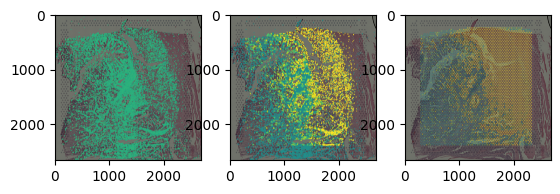

In [36]:
gene_index = 5;
labels = np.squeeze(np.array(celllabels[slide]))

fig, axs = plt.subplots(1, 3)
heatmap_imp = plotHeatmaps(image, gene_index, preds[slide], dm.detxy[slide])
heatmap_gt = plotHeatmaps(image, gene_index, labels, dm.detxy[slide])
heatmap_nodes = plotHeatmaps(image, gene_index, np.array(dm.gene_ex[slide]), dm.nodexy[slide])

axs[0].imshow(heatmap_imp)
axs[1].imshow(heatmap_gt)
axs[2].imshow(heatmap_nodes)

# Visualization Test

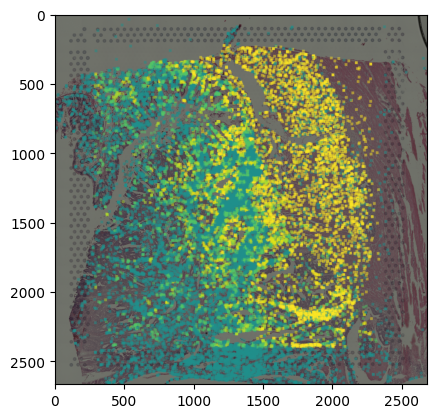

In [42]:
heatmap_gt = plotHeatmaps(image, gene_index, labels, dm.detxy[slide])
plt.imshow(heatmap_gt)
plt.show()

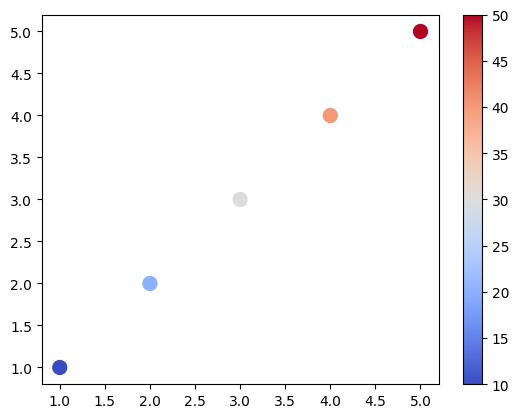

In [44]:
import matplotlib.pyplot as plt

x = [1, 2, 3, 4, 5]
y = [1, 2, 3, 4, 5]
values = [10, 20, 30, 40, 50]

plt.scatter(x, y, s=100, c=values, cmap='coolwarm')
plt.colorbar()
plt.show()


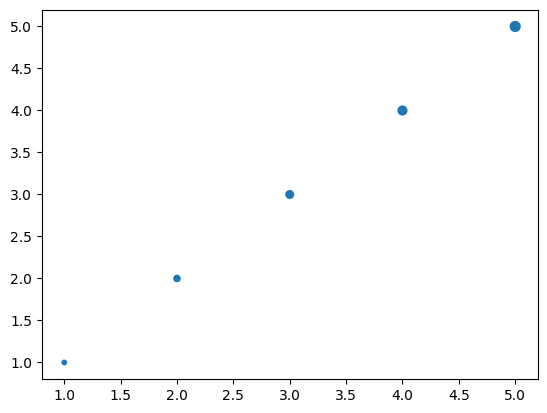

In [43]:
import matplotlib.pyplot as plt

x = [1, 2, 3, 4, 5]
y = [1, 2, 3, 4, 5]
values = [10, 20, 30, 40, 50]

plt.scatter(x, y, s=50)
plt.show()


In [52]:
cmap = matplotlib.cm.get_cmap('viridis')

In [39]:
labels[0].shape

(1000,)

In [41]:
labels[0][:300]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [54]:
intensities = labels[:, gene_index]

In [55]:
type(intensities)

numpy.ndarray

In [56]:
intensities.shape

(24015,)

In [58]:
intensities[:1000]

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , 30.99999921,
       31.00000184, 24.00000048, 36.99999829, 36.99999999,  0.        ,
       36.99999962,  0.        , 36.99999854, 36.99999915,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , 44.00000051,
       44.00000049, 43.99999836, 44.00000093, 43.99999907, 24.99999946,
       13.99999974, 44.00000189, 43.99999749, 14.00000004, 43.99

In [59]:
colors = cmap(intensities, alpha=0.5);

In [60]:
type(colors)

numpy.ndarray

In [63]:
colors.shape

(24015, 4)

In [62]:
colors[:10]

array([[0.267004, 0.004874, 0.329415, 0.5     ],
       [0.267004, 0.004874, 0.329415, 0.5     ],
       [0.267004, 0.004874, 0.329415, 0.5     ],
       [0.267004, 0.004874, 0.329415, 0.5     ],
       [0.267004, 0.004874, 0.329415, 0.5     ],
       [0.267004, 0.004874, 0.329415, 0.5     ],
       [0.267004, 0.004874, 0.329415, 0.5     ],
       [0.267004, 0.004874, 0.329415, 0.5     ],
       [0.267004, 0.004874, 0.329415, 0.5     ],
       [0.267004, 0.004874, 0.329415, 0.5     ]])

In [65]:
image = np.array(PIL.Image.open(dm.datadir + '/raw_data/' + slide + '.TIF'))
image.shape

(13323, 13419, 3)

In [75]:
downsample = 5
size = 50
new_image = image[::downsample, ::downsample, :]

In [71]:
test.shape

(2665, 2684, 3)

In [76]:
for i, (xy, color) in enumerate(zip(dm.detxy[slide], colors)):
    x, y = xy
    # Center around gene locations
    x = int(x) // downsample - size // 2
    y = int(y) // downsample - size // 2

    if len(color) == 3:
        alpha = 0.50
    else:
        alpha = color[3]
    new_image[y:y + size, x:x + size] = np.uint8((1 - alpha) * new_image[y:y + size, x:x + size].astype(np.float32) + 255 * alpha * color[:3])
    
    

In [77]:
new_image.shape

(2665, 2684, 3)

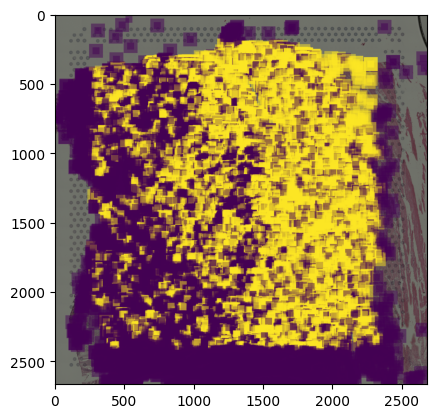

In [80]:
plt.imshow(new_image)
plt.show()

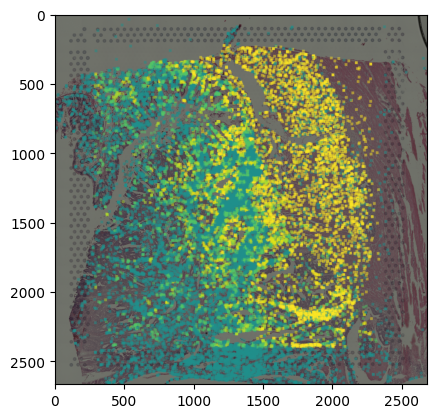

In [87]:
heatmap_gt = plotHeatmaps(image, gene_index, labels, dm.detxy[slide])
plt.imshow(heatmap_gt)
plt.show()

In [38]:
labels.shape

(24015, 1000)

In [40]:
preds[slide].shape

(24015, 1000)

In [42]:
type(celllabels[slide])

list

In [43]:
len(celllabels[slide])

24015

In [45]:
celllabels[slide][0].shape

(1, 1000)

In [46]:
type(dm.detxy[slide])

list

In [47]:
len(dm.detxy[slide])

24015

In [50]:
dm.detxy[slide][2]

(3684, 419)

In [51]:
100//5

20

# Test ends

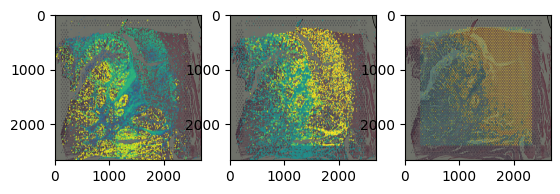

In [124]:
gene_index = 5;
labels = np.squeeze(np.array(celllabels[slide]))

fig, axs = plt.subplots(1, 3)
heatmap_imp = plotHeatmaps(image, gene_index, preds[slide], dm.detxy[slide])
heatmap_gt = plotHeatmaps(image, gene_index, labels, dm.detxy[slide])
heatmap_nodes = plotHeatmaps(image, gene_index, np.array(dm.gene_ex[slide]), dm.nodexy[slide])

axs[0].imshow(heatmap_imp)
axs[1].imshow(heatmap_gt)
axs[2].imshow(heatmap_nodes)

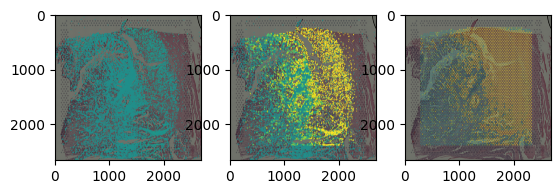

In [117]:
gene_index = 5;
labels = np.squeeze(np.array(celllabels[slide]))

fig, axs = plt.subplots(1, 3)
heatmap_imp = plotHeatmaps(image, gene_index, preds[slide], dm.detxy[slide])
heatmap_gt = plotHeatmaps(image, gene_index, labels, dm.detxy[slide])
heatmap_nodes = plotHeatmaps(image, gene_index, np.array(dm.gene_ex[slide]), dm.nodexy[slide])

axs[0].imshow(heatmap_imp)
axs[1].imshow(heatmap_gt)
axs[2].imshow(heatmap_nodes)

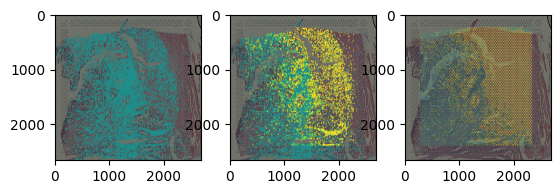

In [100]:
gene_index = 5;
labels = np.squeeze(np.array(celllabels[slide]))

fig, axs = plt.subplots(1, 3)
heatmap_imp = plotHeatmaps(image, gene_index, preds[slide], dm.detxy[slide])
heatmap_gt = plotHeatmaps(image, gene_index, labels, dm.detxy[slide])
heatmap_nodes = plotHeatmaps(image, gene_index, np.array(dm.gene_ex[slide]), dm.nodexy[slide])

axs[0].imshow(heatmap_imp)
axs[1].imshow(heatmap_gt)
axs[2].imshow(heatmap_nodes)

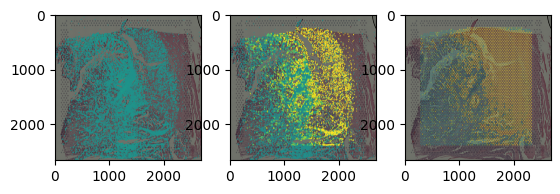

In [84]:
gene_index = 5;
labels = np.squeeze(np.array(celllabels[slide]))

fig, axs = plt.subplots(1, 3)
heatmap_imp = plotHeatmaps(image, gene_index, preds[slide], dm.detxy[slide])
heatmap_gt = plotHeatmaps(image, gene_index, labels, dm.detxy[slide])
heatmap_nodes = plotHeatmaps(image, gene_index, np.array(dm.gene_ex[slide]), dm.nodexy[slide])

axs[0].imshow(heatmap_imp)
axs[1].imshow(heatmap_gt)
axs[2].imshow(heatmap_nodes)

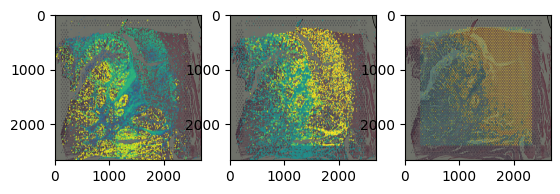

In [35]:
gene_index = 5;
labels = np.squeeze(np.array(celllabels[slide]))

fig, axs = plt.subplots(1, 3)
heatmap_imp = plotHeatmaps(image, gene_index, preds[slide], dm.detxy[slide])
heatmap_gt = plotHeatmaps(image, gene_index, labels, dm.detxy[slide])
heatmap_nodes = plotHeatmaps(image, gene_index, np.array(dm.gene_ex[slide]), dm.nodexy[slide])

axs[0].imshow(heatmap_imp)
axs[1].imshow(heatmap_gt)
axs[2].imshow(heatmap_nodes)

# Validate CNN

Median AUROC - 0.5
Median AUROC - 0.5
Median AUROC - 0.5
Median AUROC - 0.5


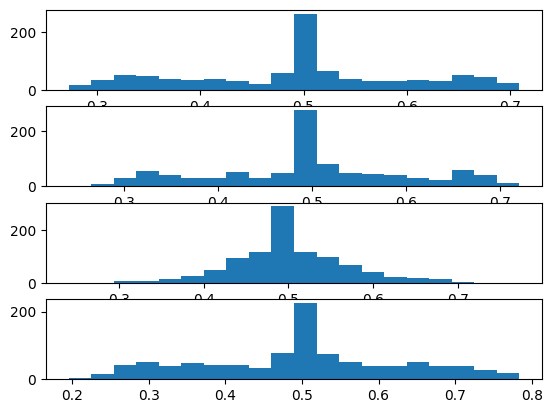

In [36]:
#plt.rcParams['figure.figsize'] = [12, 8]
#flabels = {key: select(celllabels[key], ind[key]) for key in celllabels}
#fpreds = {key: select(preds[key], ind[key]) for key in preds}
#plotAUROC(dm.snames, flabels, fpreds, dm.med_ex)

flabels = {key: np.array(select(celllabels[key], ind[key])) for key in dm.snames}
fpreds = {key: np.array(select(preds[key], ind[key])) for key in preds}
plotAUROC(dm.snames, flabels, fpreds, dm.med_ex)
#plotAP(dm.snames, flabels, fpreds, dm.med_ex, binary=True)

In [37]:
# Calculate Embeddings!!!
# embed_model = torch.nn.Sequential(*(list(model.children())[:-1]))
embed_model = model

In [38]:
slides = ['A1', 'B1', 'C1', 'D1']
celllabels, ind = generateCellLabels(slides, dm)
cellpatches = generateCellPatches(slides, dm)
transform = transforms.Compose([transforms.ToTensor()])
dataloaders = {}
for name in slides:
    dataset = EmbeddingDataset(cellpatches[name], celllabels[name], image_transform=transform, target_transform=transform)
    dataloaders[name] = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False, num_workers=4)

Average number of visium nodes used per embedding: 0.7643645248730577
Total zero embeddings: 6172
Average number of visium nodes used per embedding: 0.7026858213616489
Total zero embeddings: 7140
Average number of visium nodes used per embedding: 0.725512104283054
Total zero embeddings: 5896
Average number of visium nodes used per embedding: 0.6950401847164869
Total zero embeddings: 6868


/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (178781337 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [39]:
device = 'cuda'
embeddings = {}
for name in dm.snames:
    embeddings[name] = []
    for inputs, labels in tqdm(dataloaders[name]):
        inputs = inputs.to(device)
        labels = labels.to(device)
        torch.cuda.empty_cache()
        with torch.no_grad():
            logits = embed_model(inputs)
        for pred in numpify(logits):
            embeddings[name].append(pred)
    embeddings[name] = np.array(embeddings[name])

100%|███████████████████████████████████████████████████████████████████████| 352/352 [00:05<00:00, 68.84it/s]


In [40]:
print(embeddings['A1'][0])

[ 2.25678110e+00 -4.79955524e-01 -6.62872970e-01  2.30033159e-01
 -9.32560921e-01 -1.13081086e+00 -2.16766357e-01  4.10521030e-01
  3.15246642e-01  5.40250987e-02  1.86015415e+00 -7.58415997e-01
 -9.50717568e-01  2.45556760e+00  1.38581359e+00  2.11405843e-01
  9.07454908e-01 -8.00827622e-01  1.09718120e+00 -2.06002784e+00
  2.42316175e+00 -4.53550935e-01  9.36056376e-01 -1.04726565e+00
 -3.17632444e-02 -6.90412760e-01  7.35974967e-01 -2.23976874e+00
 -8.47924873e-03  3.18286657e+00  4.49779183e-01  6.92433953e-01
 -5.82760692e-01 -2.21344137e+00 -4.38014388e-01 -9.01443362e-01
 -3.38155448e-01  5.09549618e-01 -2.94445539e+00  7.78926253e-01
 -6.35823086e-02 -2.81870842e+00  1.27027667e+00 -1.44534659e+00
 -4.59911346e-01 -5.30900478e-01 -2.96639681e-01  1.43581223e+00
 -5.11956215e-01 -2.02251613e-01  5.47006577e-02 -3.28287780e-01
  2.24140716e+00 -8.45957160e-01  1.03289270e+00  2.31267118e+00
 -1.37282753e+00  1.45298731e+00  7.34575093e-03  5.11833787e-01
  3.14424127e-01  4.33499

In [ ]:
# Save cnn embeddings
storeDir = './CNN_models/'
with open(storeDir + 'cnn_embed.pickle', 'wb') as handle:
    pickle.dump(embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Feature vectors

In [41]:
# Load cnn embeddings
storeDir = '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Lutz/CELL2RNA/spatial_omics/code/GNN/store/'
with open(storeDir + 'cnn_embed.pickle', 'rb') as handle:
    cnn_embeddings = pickle.load(handle)

In [ ]:
# TODO: save feature vectors to avoid recomputation!
storeDir = './CNN_models'
for name in dm.snames:
    nx = [x for x,y in dm.detxy[name]]
    ny = [y for x,y in dm.detxy[name]]
    d = {'X' : nx, 'Y' : ny, 'Embedding' : list(np.squeeze(cnn_embeddings[name]))}
    df = pd.DataFrame(data=d)
    pickle.dump(df, open(f'{storeDir}/nodes/{name}.pickle', "wb"))

# Graph

In [42]:
import torch
import os 
import sys
import numpy as np
import glob, pandas as pd
import pickle
import torch_geometric
import scipy.sparse as sps
from sklearn.preprocessing import LabelEncoder
from torch_cluster import knn_graph
import torch_geometric
from torch_geometric.data import Data 
from torch_geometric.utils import train_test_split_edges
from torch_geometric.utils.convert import to_networkx
from torch_geometric.data import InMemoryDataset,DataLoader
from torch_cluster import radius_graph
from torch_geometric.utils import subgraph
from sklearn.model_selection import train_test_split
from graphgen import neighborFinder

In [43]:
# for inspecting positions.
storeDir = '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Lutz/CELL2RNA/spatial_omics/code/GNN/store'
df = pickle.load(open(os.path.join(storeDir,f"nodes/A1.pickle"), "rb"))
inv = np.stack([[] == x for x in df.Embedding.values])
emb = df.Embedding.values
pos = df[['X','Y']].values
for p in pos:
    pass

/scratch/ipykernel_258362/3842239712.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  inv = np.stack([[] == x for x in df.Embedding.values])


In [44]:
# Graph pooling and then check with neighbors???
storeDir = '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Lutz/CELL2RNA/spatial_omics/code/GNN/store'
def get_graph_dataset(basename, data, embedding_dir=f'{storeDir}/nodes', \
                      noderad=150, graphrad=100, binary=False):
    df = pickle.load(open(os.path.join(embedding_dir,f"{basename}.pickle"), "rb"))
    emb = df.Embedding.values
    pos = df[['X','Y']].values
    
    # make a graph for each visium node.
    datasets = []
    avg = 0
    n = neighborFinder(data.detxy[basename], tile_factor=100)
    for ind in tqdm(range(len(data.nodexy[basename]))):
        spos, semb = [], []
        neighbors = n.find(data.nodexy[basename][ind], noderad)
        for index in neighbors:
            spos.append(pos[index])
            semb.append(emb[index])
        
        if (len(semb) == 0 or len(spos) == 0): continue;
        avg += len(spos)
        semb = torch.tensor(np.stack([x for x in semb]), dtype=torch.float32)
        spos = torch.tensor(np.array(spos), dtype=torch.float32).cuda()
        sgraph = radius_graph(spos, r=graphrad, batch=None, loop=True)
        sgraph = sgraph.detach().cpu()
        sgraph = torch_geometric.utils.add_remaining_self_loops(sgraph)[0]
        if (binary):
            slbl = torch.tensor(data.gene_ex_binary[basename][ind], dtype=torch.float32)
        else:
            slbl = torch.tensor(data.gene_ex[basename][ind], dtype=torch.float32)
        dataset = Data(x=semb, edge_index=sgraph, edge_attr=None, y=slbl, pos=spos, global_id=ind)
        datasets.append(dataset)
    print("Average Graph Size: ", avg / len(datasets))
    return datasets

In [45]:
dm = dataManager(['A1', 'B1', 'C1', 'D1'])

Loading Detections...


/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (178781337 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


Fetching Expression...
Loading slide from cache: A1
Loading slide from cache: B1
Loading slide from cache: C1
Loading slide from cache: D1


In [46]:
datasets = {}
for name in dm.snames:
    datasets[name] = get_graph_dataset(name, dm, binary=True)
    print("Number of Graphs: ", len(datasets[name]))

100%|███████████████████████████████████████████████████████████████████| 4950/4950 [00:02<00:00, 1748.75it/s]


Average Graph Size:  16.817283431455003
Number of Graphs:  4756


100%|███████████████████████████████████████████████████████████████████| 4922/4922 [00:02<00:00, 1906.76it/s]


Average Graph Size:  14.63923361637274
Number of Graphs:  4593


100%|███████████████████████████████████████████████████████████████████| 4887/4887 [00:03<00:00, 1585.89it/s]


Average Graph Size:  12.943474646716542
Number of Graphs:  4812


100%|███████████████████████████████████████████████████████████████████| 4169/4169 [00:02<00:00, 1894.17it/s]

Average Graph Size:  16.504223864836327
Number of Graphs:  3788


In [47]:
index = 6
print(datasets['A1'][index])
print(numpify(datasets['A1'][index].pos))
print(numpify(datasets['A1'][index].edge_index))

Data(x=[5, 1000], edge_index=[2, 17], y=[1000], pos=[5, 2], global_id=7)
[[2087. 1249.]
 [2219. 1272.]
 [2256. 1248.]
 [2271. 1258.]
 [2258. 1264.]]
[[2 3 4 1 3 4 1 2 4 1 2 3 0 1 2 3 4]
 [1 1 1 2 2 2 3 3 3 4 4 4 0 1 2 3 4]]


In [ ]:
# Save graphs.
storeDir = './GNN_models/'

# with open(f'./GCN_data/CNN_data/{val}_same_tutorial_0_224.pkl','wb') as f:
#         pickle.dump(dict(X=X,y=y),f,pickle.HIGHEST_PROTOCOL)

with open('/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Lutz/CELL2RNA/all_code/GNN_models/graphs.pickle', 'wb') as handle:
    pickle.dump(datasets, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [125]:
import sys, os
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pickle
import os,glob, pandas as pd
from sklearn.metrics import f1_score
import copy
from collections import Counter
import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.nn import GCNConv, GATConv, DeepGraphInfomax, SAGEConv, ClusterGCNConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn import DenseGraphConv
from torch_geometric.utils import to_dense_batch, to_dense_adj, dense_to_sparse
from torch_geometric.nn import GINEConv
from torch_geometric.utils import dropout_adj
from torch_geometric.nn import APPNP
from torch_cluster import knn_graph
from torch_geometric.data import Data 
from torch_geometric.utils import train_test_split_edges
from torch_geometric.utils.convert import to_networkx
from torch_geometric.data import InMemoryDataset
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
# for use in validation.
from sklearn.metrics import average_precision_score, roc_auc_score

In [126]:
EPS = 1e-15

class GCNNet(torch.nn.Module):
    def __init__(self, inp_dim, out_dim, hidden_topology=[32,64,128, 128]):
        super(GCNNet, self).__init__()
        self.out_dim=out_dim
        self.convs = nn.ModuleList([GATConv(inp_dim, hidden_topology[0])] \
                                   + [GATConv(hidden_topology[i],hidden_topology[i+1]) \
                                     for i in range(len(hidden_topology[:-1]))])
        self.fc = nn.Linear(hidden_topology[-1], out_dim)
        self.ReLU = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, edge_index, batch):
#         l_net = nn.Linear(1000, 512)
#         l_net.to(device)
#         x.to(device)
#         x = l_net(x)
        for conv in self.convs:
            x = conv(x, edge_index)
#             x = F.relu(x)
            x = self.ReLU(x)
        x = self.fc(x)
        x = global_mean_pool(x, batch)
        return x
    
    def infer(self, x, edge_index, batch):
        x = self.forward(x, edge_index, batch)
        x = self.sigmoid(x)
        return x

In [127]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
def fit_model(graphs,
                use_model=None,
                n_batches_backward=1,
                n_epochs=1500,
                lr=1e-2,
                eta_min=1e-4,
                T_max=20,
                wd=0,
                hidden_topology=[32,64,128],
                gpu_id=0,
                batch_size=1,
                storeDir='/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/spatial_omics/code/GNN/store/gnn_models'
                ):
    print(gpu_id); torch.cuda.set_device(gpu_id)

    train_dataset = []
    for name in ['B1', 'C1', 'D1']:
        train_dataset.extend(graphs[name])
        
    val_dataset = []
    for name in ['A1']:
        val_dataset.extend(graphs[name])
    
    # Readout
    print(len(train_dataset), " training graphs, ", len(val_dataset), " validation graphs")
    
    print(f"In Dim: {len(train_dataset[0].x[0])}, Out Dim: {len(train_dataset[0].y)}")
    model = GCNNet(len(train_dataset[0].x[0]), len(train_dataset[0].y))
    if use_model:
        model.load_state_dict(torch.load(use_model))
    model=model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())

    optimizer = torch.optim.Adam(model.parameters(),lr=lr, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max, eta_min=eta_min, last_epoch=-1)
    criterion = nn.functional.binary_cross_entropy_with_logits

    # dataloaders
    dataloaders={}
    dataloaders['train'] = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dataloaders['val'] = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    print(len(dataloaders['train']), len(dataloaders['val']))

    n_total_batches=0
    train_val_loss = []
    best_loss = 1e9
    for epoch in range(n_epochs):
        trainloss = 0
        for i, data in enumerate(dataloaders['train']):
            n_total_batches += 1
            model.train(True)
            x = data.x.to(device)
            edge_index = data.edge_index.to(device)
            y = data.y.to(device)
            batch = data.batch.to(device)
            y_out = torch.flatten(model(x, edge_index, batch))
            loss = criterion(y_out, y, weight=torch.tensor([1]).cuda()) / n_batches_backward
            loss.backward()
            trainloss += loss.item()
            if (n_total_batches % n_batches_backward == 0):
                optimizer.step()
                optimizer.zero_grad()
            del x, edge_index, loss, y_out, batch
        trainloss /= len(dataloaders['train'])
        scheduler.step()
                    
        valloss = 0
        for i, data in enumerate(dataloaders['val']):
            model.train(False)
            x = data.x.to(device)
            edge_index = data.edge_index.to(device)
            y = data.y.to(device)
            batch = data.batch.to(device)
            y_out = torch.flatten(model(x, edge_index, batch))
            loss = criterion(y_out, y, weight=torch.tensor([1]).cuda()) 
            valloss += loss.item()
            del x, edge_index, loss, y_out, batch
        valloss /= len(dataloaders['val'])
        
        if valloss < best_loss:
            best_loss = valloss
            best_model_wts = copy.deepcopy(model.state_dict())
        
        if (epoch % 50 == 0 and epoch != 0):
            with open(f'{storeDir}/modelkey.txt', "r+") as f:
                modelkey = int(str(f.read()))
                torch.save(best_model_wts, f"{storeDir}/GATv{modelkey}_{epoch}.pth")
        
        print(f"Epoch: {epoch} | Training Loss: {trainloss} | Validation Loss: {valloss}", flush=True)
        train_val_loss.append((trainloss, valloss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [128]:
Dir = '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Lutz/CELL2RNA/all_code/GNN_models'
graphs = pickle.load(open(f"{Dir}/graphs.pickle", "rb"))

In [129]:
graphs.keys()

dict_keys(['A1', 'B1', 'C1', 'D1'])

In [105]:
storeDir = './GNN_models'
gnn_model = fit_model(graphs, lr=1e-3, n_epochs=5, gpu_id=0, batch_size=256, storeDir=storeDir)

0
13193  training graphs,  4756  validation graphs
In Dim: 1000, Out Dim: 1000
52 19
Epoch: 0 | Training Loss: 0.5859449861141351 | Validation Loss: 0.6164759272023251
Epoch: 1 | Training Loss: 0.5215376575405781 | Validation Loss: 0.5811693135060763
Epoch: 2 | Training Loss: 0.5084275053097651 | Validation Loss: 0.5715076703774301
Epoch: 3 | Training Loss: 0.5095485523343086 | Validation Loss: 0.5822560473492271
Epoch: 4 | Training Loss: 0.5077590432304603 | Validation Loss: 0.5637910899363066


In [150]:
graphs['A1']

{'A1': [Data(x=[1, 1000], edge_index=[2, 1], y=[1000], pos=[1, 2], global_id=1),
  Data(x=[4, 1000], edge_index=[2, 16], y=[1000], pos=[4, 2], global_id=2),
  Data(x=[4, 1000], edge_index=[2, 6], y=[1000], pos=[4, 2], global_id=3),
  Data(x=[5, 1000], edge_index=[2, 11], y=[1000], pos=[5, 2], global_id=4),
  Data(x=[2, 1000], edge_index=[2, 2], y=[1000], pos=[2, 2], global_id=5),
  Data(x=[3, 1000], edge_index=[2, 3], y=[1000], pos=[3, 2], global_id=6),
  Data(x=[5, 1000], edge_index=[2, 17], y=[1000], pos=[5, 2], global_id=7),
  Data(x=[5, 1000], edge_index=[2, 17], y=[1000], pos=[5, 2], global_id=8),
  Data(x=[4, 1000], edge_index=[2, 16], y=[1000], pos=[4, 2], global_id=9),
  Data(x=[5, 1000], edge_index=[2, 25], y=[1000], pos=[5, 2], global_id=10),
  Data(x=[6, 1000], edge_index=[2, 20], y=[1000], pos=[6, 2], global_id=11),
  Data(x=[7, 1000], edge_index=[2, 29], y=[1000], pos=[7, 2], global_id=12),
  Data(x=[3, 1000], edge_index=[2, 5], y=[1000], pos=[3, 2], global_id=13),
  Data(

In [106]:
storeDir = '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Lutz/CELL2RNA/all_code/GNN_models'
with open('/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Lutz/CELL2RNA/all_code/GNN_models/modelkey.txt', "r+") as f:
    modelkey = int(str(f.read()))
    torch.save(gnn_model.state_dict(), f"{storeDir}/GATv{modelkey}.pth")
    
with open('/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Lutz/CELL2RNA/all_code/GNN_models/modelkey.txt', "w") as f:
    f.write(str(modelkey+1))

# Validate GNN

In [130]:
Dir = '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/spatial_omics/code/GNN/store/gnn_models_good'
gnn_model = GCNNet(inp_dim = 1000, out_dim = 1000)
modelkey = 5
#state_dict = torch.load(f"{Dir}/GATv{modelkey}.pth", map_location=device)
state_dict = torch.load('/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Lutz/CELL2RNA/all_code/GNN_models/GATv1.pth', map_location=device)
gnn_model.load_state_dict(state_dict)
gnn_model.eval();
gnn_model.to(device);

In [131]:
# Run model on all graphs to obtain all predictions.
graph_data = '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Lutz/CELL2RNA/all_code/GNN_models/graphs.pickle'
graphs = pickle.load(open(graph_data, "rb"))

In [132]:
print([key for key in graphs])
#print(data['B1'])

['A1', 'B1', 'C1', 'D1']


In [133]:
gnn_model.eval();
preds = {}
valid = {}
for name in graphs:
    preds[name] = []
    valid[name] = []
    dataloader = DataLoader(graphs[name], batch_size=256)
    for i, data in tqdm(enumerate(dataloader)):
        x = data.x.to(device)
        edge_index = data.edge_index.to(device)
        y = data.y.to(device)
        batch = data.batch.to(device)
        batch_preds = gnn_model.infer(x,edge_index,batch)
        ids = numpify(data.global_id)
        for i, pred in enumerate(numpify(batch_preds)):
            preds[name].append(pred)
            valid[name].append(ids[i].item())
        del x, edge_index, y, batch_preds, batch
    valid[name] = np.array(valid[name])

19it [00:00, 38.01it/s]
18it [00:00, 34.57it/s]
19it [00:00, 50.14it/s]
15it [00:00, 46.77it/s]


In [134]:
from visualize_2 import plotHeatmaps, plotAUROC, plotAP

Median AUROC - 0.7372752804668694
Median AUROC - 0.736045464622922
Median AUROC - 0.6280016781655904
Median AUROC - 0.7676732570249045
Median AP - 0.6420618318819384
Median AP - 0.6301038479938625
Median AP - 0.44406846724331933
Median AP - 0.3357366601188907


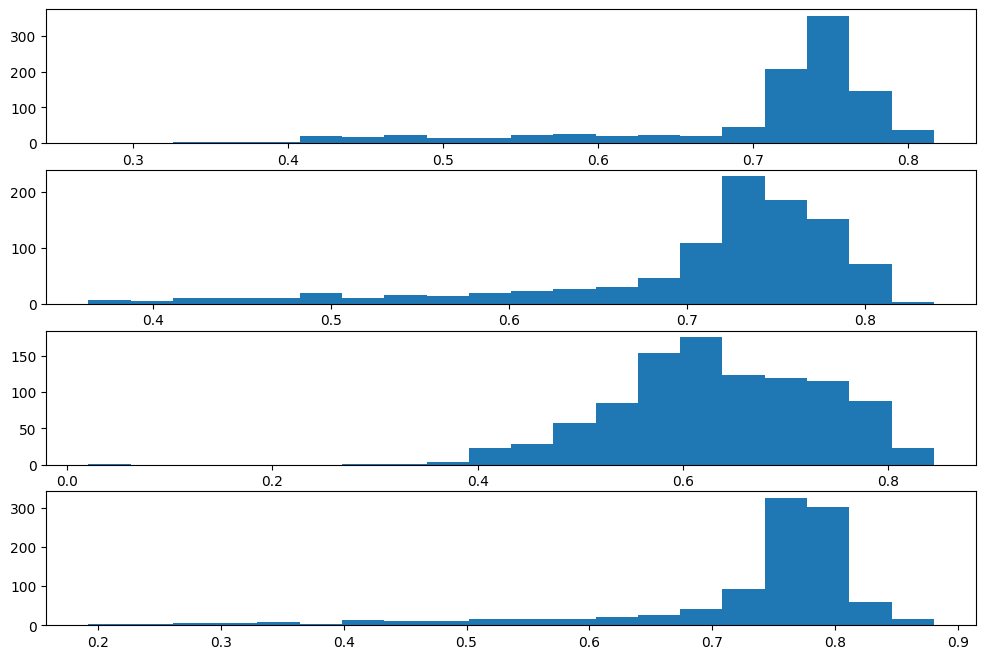

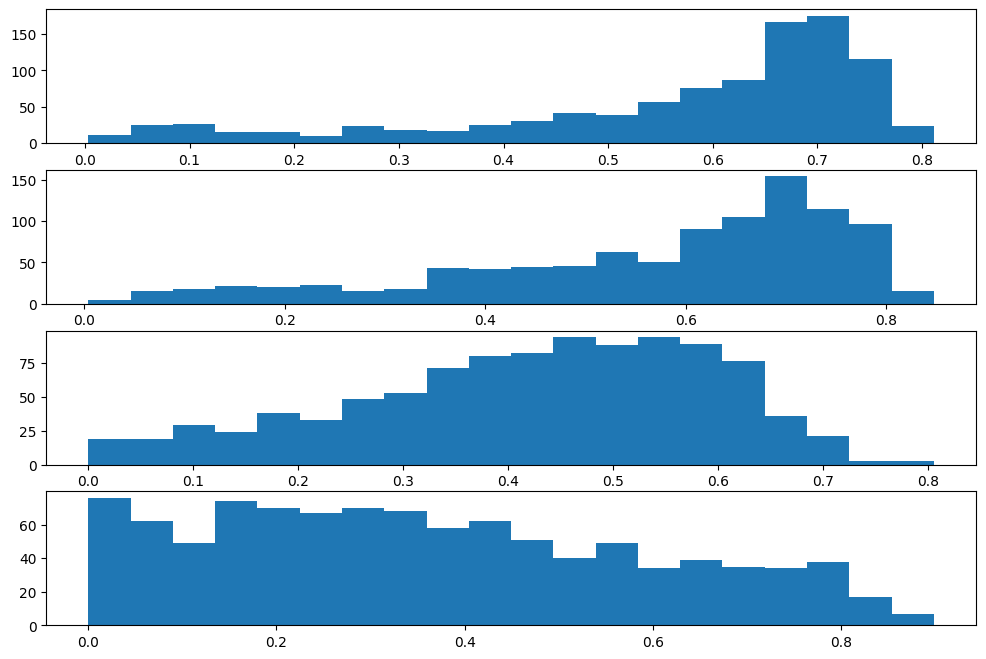

In [135]:
plt.rcParams['figure.figsize'] = [12, 8]
# B held out.
flabels = {key: np.array(select(dm.gene_ex_binary[key], valid[key])) for key in dm.snames}
fpreds = {key: np.array(preds[key]) for key in preds}
plotAUROC(dm.snames, flabels, fpreds, dm.med_ex, binary=True)
plotAP(dm.snames, flabels, fpreds, dm.med_ex, binary=True)

In [136]:
slide = 'B1';
image = np.array(PIL.Image.open(dm.datadir + '/raw_data/' + slide + '.TIF'))

/dartfs-hpc/rc/home/y/f005dcy/.conda/envs/jupyter/lib/python3.8/site-packages/PIL/Image.py:3074: DecompressionBombWarning: Image size (178781337 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


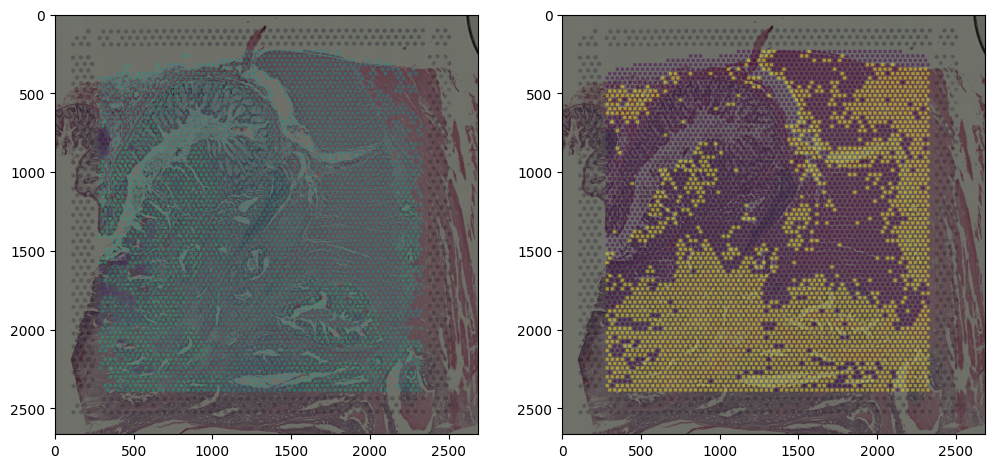

In [143]:
gene_index = 18;

fig, axs = plt.subplots(1, 2)
# filter positions to ones predicted on.
pos = np.array([dm.nodexy[slide][i] for i in valid[slide]])
heatmap_imp = plotHeatmaps(image, gene_index, np.array(preds[slide]), pos, binary=True)
heatmap_nodes = plotHeatmaps(image, gene_index, np.array(dm.gene_ex_binary[slide], dtype=np.float32), dm.nodexy[slide], binary=True)
axs[0].imshow(heatmap_imp)
axs[1].imshow(heatmap_nodes)




In [7]:
!pwd

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Lutz/CELL2RNA/spatial_omics/code/MaskRCNN


In [8]:
os.chdir("/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Lutz/CELL2RNA/all_code")

In [10]:
data_a1 = pd.read_csv('../A1_Histology1K.csv', index_col = 0)

In [11]:
data_a1

,g,pattern,membership
1060,IL20,4,1.000000
2145,SOD3,4,0.999673
2148,IGHG3,2,1.000000
2150,IGLC1,2,1.000000
2162,TFCP2L1,3,1.000000
...,...,...,...
3722,FOXF2,3,1.000000
3723,CDK16,3,1.000000
3724,NHP2,0,1.000000
3726,RNF114,0,1.000000


In [18]:
data_a1['pattern'].value_counts()

3    730
0    188
4     41
1     23
2     18
Name: pattern, dtype: int64

In [12]:
data_a1_1 = pd.read_csv('../A1patterns1K.csv', index_col = 0)

In [13]:
data_a1_1

,0,1,2,3,4
TTGTTTGTGTAAATTC-1,0.086144,-0.150067,0.208339,-0.019209,0.052107
TTGTTTGTATTACACG-1,-0.324242,0.248806,-0.340815,-0.300476,-0.084859
TTGTTTCCATACAACT-1,-0.115078,0.145316,-0.183371,-0.012031,0.015397
TTGTTTCATTAGTCTA-1,-0.247900,0.210252,-0.283134,-0.176117,-0.042498
TTGTTTCACATCCAGG-1,-0.226260,0.157170,-0.227426,-0.179629,-0.029585
...,...,...,...,...,...
AAACAGAGCGACTCCT-1,-0.001251,-0.287308,0.323068,-0.232634,-0.049344
AAACACCAATAACTGC-1,-0.228956,0.247191,-0.313297,-0.120987,-0.043025
AAACAATCTACTAGCA-1,0.160073,-0.127539,0.207976,0.084639,0.077630
AAACAAGTATCTCCCA-1,0.074455,-0.050686,0.045159,0.081120,-0.003653


In [14]:
data_b1 = pd.read_csv('../B1_Histology1K.csv', index_col = 0)

In [15]:
data_b1

,g,pattern,membership
5321,PTGDR,0,1.000000
5356,SIAE,0,1.000000
5358,SLC44A4,0,1.000000
5359,CPSF1,4,1.000000
5360,KXD1,4,1.000000
...,...,...,...
6776,PITX2,4,0.996142
6777,SAMD1,4,1.000000
6780,MMP2,3,1.000000
6781,SRP72,4,1.000000
